In [125]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [126]:
# Read the csv file with a separator
df = pd.read_csv('../data/cars.csv', sep=';')

# Replace '?' with NaN and convert columns to numeric
df.replace('?', pd.NA, inplace=True)

# Convert numeric columns 
numeric_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop any rows with missing values
df.dropna(inplace=True)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [127]:
df[numeric_cols].dtypes


mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model year        int64
origin            int64
dtype: object

In [128]:
# To get a more detailed diagnostic performance metrics we use the custom evaluation function

def evaluate(H, Y, beta=1.0):
    H = np.array(H)
    Y = np.array(Y)

    tp = np.sum((Y == 1) & (H == 1))
    tn = np.sum((Y == 0) & (H == 0))
    fp = np.sum((Y == 0) & (H == 1))
    fn = np.sum((Y == 1) & (H == 0))

    # Handle divisions safely
    def safe_div(a, b):
        return a / b if b != 0 else np.nan

    accuracy = safe_div(tp + tn, tp + fp + fn + tn)
    sensitivity = safe_div(tp, tp + fn)
    specificity = safe_div(tn, fp + tn)
    precision = safe_div(tp, tp + fp)
    recall = sensitivity
    f_score = safe_div(( (beta**2 + 1) * precision * recall ), (beta**2 * precision + recall))
    auc = safe_div(sensitivity + specificity, 2)
    youden = sensitivity - (1 - specificity)
    p_plus = safe_div(sensitivity, 1 - specificity)
    p_minus = safe_div(1 - sensitivity, specificity)
    dp = safe_div((np.sqrt(3) / np.pi) * (np.log(sensitivity/(1 - sensitivity)) + np.log(specificity/(1 - specificity))), 1)

    result = {
        "tp": tp, "tn": tn, "fp": fp, "fn": fn,
        "accuracy": accuracy, "sensitivity": sensitivity, "specificity": specificity,
        "precision": precision, "recall": recall, "f-score": f_score,
        "AUC": auc, "Youden": youden, "p+": p_plus, "p-": p_minus, "DP": dp
    }

    return result

In [129]:
# First we create a binary target for logistic regression.
median_mpg = df['mpg'].median()
df['high_efficiency'] = (df['mpg'] > median_mpg).astype(int)

In [130]:
# Now we train the models with the exact same data partitions

from sklearn.model_selection import train_test_split

# Features
features = ['weight', 'horsepower', 'cylinders']
X = df[features]

# Targets
y_reg = df['mpg']
median_mpg = df['mpg'].median()
y_log = (df['mpg'] > median_mpg).astype(int)  # 1 = high efficiency

# One split for both
X_train, X_test, y_train_reg, y_test_reg, y_train_log, y_test_log = train_test_split(
    X, y_reg, y_log, test_size=0.2, random_state=42
)

In [131]:
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train_reg)

# Predictions
y_pred_reg = reg_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R² Score: {r2:.3f}")



Mean Squared Error (MSE): 17.677
R² Score: 0.654


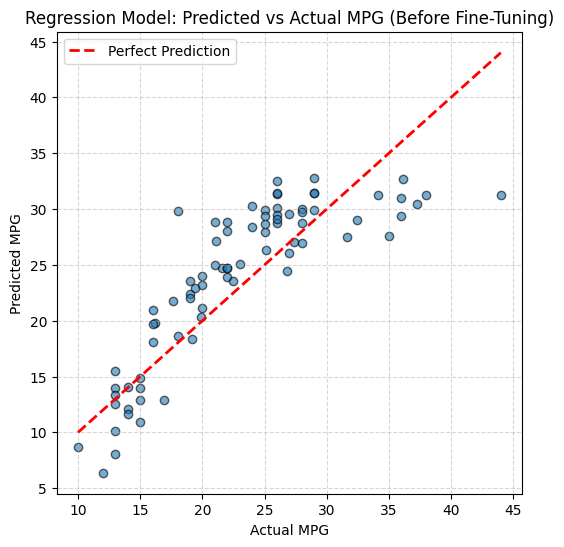

In [132]:
import matplotlib.pyplot as plt

# Plotting the regression model

plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6, edgecolor='k')  # scatter plot
plt.plot(
    [y_test_reg.min(), y_test_reg.max()],
    [y_test_reg.min(), y_test_reg.max()],
    'r--',
    linewidth=2,
    label='Perfect Prediction'
)
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Regression Model: Predicted vs Actual MPG (Before Fine-Tuning)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("regression_before_finetuning.png")
plt.show()


In [133]:
# Logisic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Train model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train_log)

# Predictions
y_pred_log = log_model.predict(X_test)

# Use your custom evaluation
metrics = evaluate(y_pred_log, y_test_log)

print("Classification Metrics:")
for k, v in metrics.items():
    print(f"{k:12s}: {v:.3f}")

# Optional: Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_log, y_pred_log))

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
param_grid_log = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2'],  # keep l2 for lbfgs; to use l1 you'd need solver='saga' or 'liblinear'
    # 'logisticregression__solver': ['lbfgs']  # default ok
}

log_grid = GridSearchCV(log_pipe, param_grid_log, cv=5, scoring='accuracy')
log_grid.fit(X_train, y_train_log)

print("Best logistic params:", log_grid.best_params_)
best_log = log_grid.best_estimator_

# Predictions & evaluation
y_pred_log_cv = best_log.predict(X_test)
metrics_tuned = evaluate(y_pred_log_cv, y_test_log)
print("Logistic tuned metrics:")
for k,v in metrics_tuned.items():
    print(f"{k:12s}: {v:.4f}")

# ROC AUC
from sklearn.metrics import roc_curve, auc
y_prob = best_log.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test_log, y_prob)
print("AUC:", auc(fpr, tpr))

Classification Metrics:
tp          : 36.000
tn          : 36.000
fp          : 6.000
fn          : 1.000
accuracy    : 0.911
sensitivity : 0.973
specificity : 0.857
precision   : 0.857
recall      : 0.973
f-score     : 0.911
AUC         : 0.915
Youden      : 0.830
p+          : 6.811
p-          : 0.032
DP          : 2.964

Confusion Matrix:
[[36  6]
 [ 1 36]]
Best logistic params: {'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}
Logistic tuned metrics:
tp          : 36.0000
tn          : 36.0000
fp          : 6.0000
fn          : 1.0000
accuracy    : 0.9114
sensitivity : 0.9730
specificity : 0.8571
precision   : 0.8571
recall      : 0.9730
f-score     : 0.9114
AUC         : 0.9151
Youden      : 0.8301
p+          : 6.8108
p-          : 0.0315
DP          : 2.9635
AUC: 0.9510939510939511


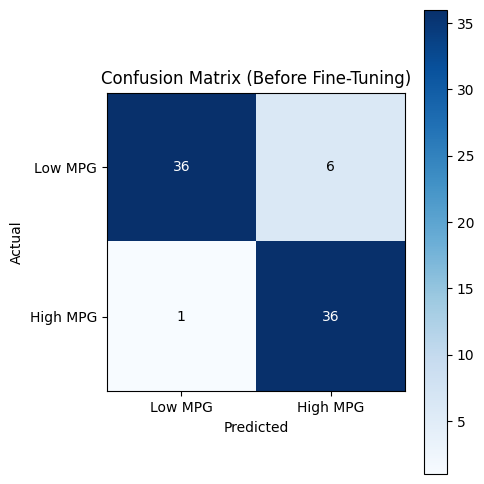

In [134]:
# Plotting the logical regression model

# Compute confusion matrix
cm = confusion_matrix(y_test_log, y_pred_log)

# Plot
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Before Fine-Tuning)")
plt.colorbar()

# Label the axes
classes = ['Low MPG', 'High MPG']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Add numbers inside the boxes
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
        
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig("confusion_matrix_before_finetuning.png")
plt.show()

In [135]:
# Fine tuning the Regression models

from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

In [136]:
# defining the alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100] 

# Running a cross-validation on each value
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train_reg)

print("Best alpha for ridge: ", ridge_cv.alpha_)

# Now predicting and evaluating 
y_pred_ridge = ridge_cv.predict(X_test)

print("Ridge MSE:", mean_squared_error(y_test_reg, y_pred_ridge))
print("Ridge R2:", r2_score(y_test_reg, y_pred_ridge))

Best alpha for ridge:  100.0
Ridge MSE: 17.703561171652435
Ridge R2: 0.6531473574967886


In [137]:
# Fine tuning Regression model with L2 (Lassso)                                                                                                                                                                                            

lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train_reg)

print("Best alpha for lasso: ", lasso_cv.alpha_)

y_pred_lasso = lasso_cv.predict(X_test)

print("Lasso MSE:", mean_squared_error(y_test_reg, y_pred_lasso))
print("Lasso R2:", r2_score(y_test_reg, y_pred_lasso))

Best alpha for lasso:  0.001
Lasso MSE: 17.677428914950305
Lasso R2: 0.6536593472712653


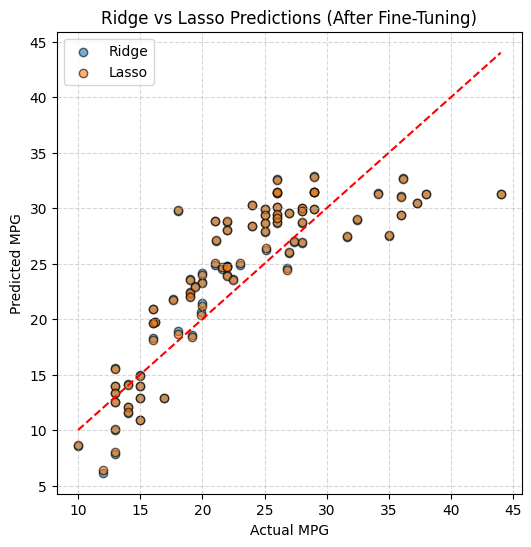

Ridge best alpha: 10
Ridge CV R2 (best): 0.706594746613012
Lasso best alpha: 0.01
Lasso CV R2 (best): 0.7060002259171779
Ridge test MSE: 17.48341356837138
Ridge test R2:  0.6574605449509068
Lasso test MSE: 17.652212481696655
Lasso test R2:  0.6541533940013965


In [138]:
# Comparison between ridge and lasso visually 

plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_ridge, alpha=0.6, label='Ridge', edgecolor='k')
plt.scatter(y_test_reg, y_pred_lasso, alpha=0.6, label='Lasso', edgecolor='k')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Ridge vs Lasso Predictions (After Fine-Tuning)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("ridge_vs_lasso_after_finetuning.png")
plt.show()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Use pipelines so scaler is fitted only on training folds inside CV
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(max_iter=10000))])

param_grid_ridge = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(ridge_pipe, param_grid_ridge, cv=5, scoring='r2')
lasso_grid = GridSearchCV(lasso_pipe, param_grid_lasso, cv=5, scoring='r2')

ridge_grid.fit(X_train, y_train_reg)
lasso_grid.fit(X_train, y_train_reg)

print("Ridge best alpha:", ridge_grid.best_params_['ridge__alpha'])
print("Ridge CV R2 (best):", ridge_grid.best_score_)
print("Lasso best alpha:", lasso_grid.best_params_['lasso__alpha'])
print("Lasso CV R2 (best):", lasso_grid.best_score_)

# Evaluate on test set
y_pred_ridge = ridge_grid.predict(X_test)
y_pred_lasso = lasso_grid.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("Ridge test MSE:", mean_squared_error(y_test_reg, y_pred_ridge))
print("Ridge test R2: ", r2_score(y_test_reg, y_pred_ridge))
print("Lasso test MSE:", mean_squared_error(y_test_reg, y_pred_lasso))
print("Lasso test R2: ", r2_score(y_test_reg, y_pred_lasso))

In [139]:
# Now fine tuning of the Logical regression model

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc

# Values for C (inverse of alpha) the smaller the C = stronger regunarization
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

In [140]:
# logistic regression with crass-validation

log_cv = LogisticRegressionCV(Cs=C_values, cv=5, max_iter=1000)
log_cv.fit(X_train, y_train_log)

print("Best C: ", log_cv.C_[0])

# predict and evaluate
y_pred_log_cv = log_cv.predict(X_test)
print("Accuracy after fine tuning: ", evaluate(y_pred_log_cv, y_test_log))

Best C:  1.0
Accuracy after fine tuning:  {'tp': np.int64(36), 'tn': np.int64(36), 'fp': np.int64(6), 'fn': np.int64(1), 'accuracy': np.float64(0.9113924050632911), 'sensitivity': np.float64(0.972972972972973), 'specificity': np.float64(0.8571428571428571), 'precision': np.float64(0.8571428571428571), 'recall': np.float64(0.972972972972973), 'f-score': np.float64(0.9113924050632912), 'AUC': np.float64(0.915057915057915), 'Youden': np.float64(0.8301158301158301), 'p+': np.float64(6.810810810810809), 'p-': np.float64(0.03153153153153147), 'DP': np.float64(2.963546307093121)}


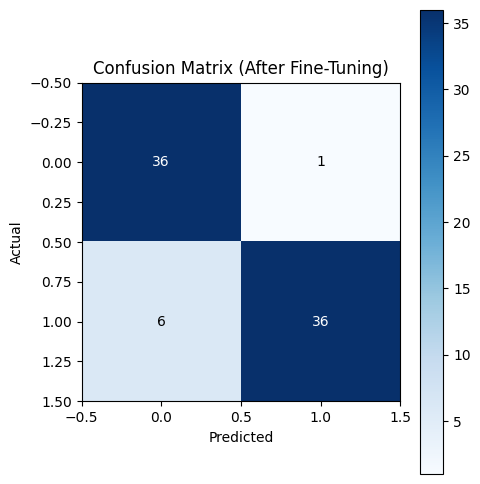

In [141]:
# visualize and evaluate

cm = confusion_matrix(y_pred_log_cv, y_test_log)

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (After Fine-Tuning)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Add numbers inside the boxes
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig("confusion_matrix_after_finetuning.png")
plt.show()

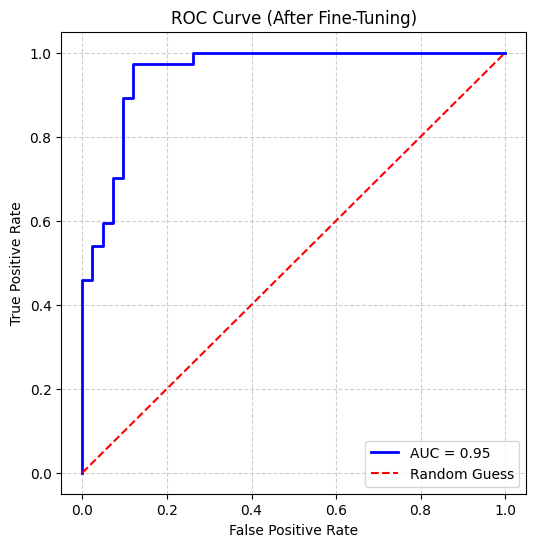

In [143]:
y_prob_log_cv = log_cv.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test_log, y_prob_log_cv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (After Fine-Tuning)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("roc_curve_after_finetuning.png")
plt.show()

